In [193]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
from IPython.core.debugger import set_trace
%matplotlib notebook

In [191]:
BASE_PATH = './pack/data/matches/'

In [2]:
def find_nearest_idx(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx

In [189]:
class Game():
    def __init__(self, game_id):
        self.game_id = game_id
        self.players = None # Dictionary with keys of player ids
        self.events = None # List of events
        self.id_data = None
        self.id_kills = None
        self.constructGame(game_id)
        
    def constructGame(self, game_id):
        dataFile = BASE_PATH + game_id + '/ticks.csv'
        id_data = pd.read_csv(dataFile)
        self.id_data = id_data
        
        killFile = BASE_PATH + game_id + '/kills.csv'
        id_kills = pd.read_csv(killFile)
        self.id_kills = id_kills
        
        self.loadPlayers()
        self.loadEvents()
    
    def loadPlayers(self):
        killer_ids = np.unique(self.id_kills['killer_recording_id'])

        killers = {}
        for killer in killer_ids:
            kills = self.id_kills['killer_recording_id'] == killer
            killers[killer] = self.id_kills[kills]

        player_ids = np.unique(self.id_data['recording_id'])

        players = {}

        for player_id in player_ids:
            player = Player(player_id)

            # Save player's ticks
            tick_indices = self.id_data['recording_id'] == player_id
            player.tick_indices = tick_indices

            # gathering all the player's kills
            kill_indices = self.id_kills['killer_recording_id'] == player_id
            player.kill_indices = kill_indices

            # Save kill timestamps
            kill_stamps = self.player_kill_ticks(player.tick_indices, player.kill_indices)
            player.kill_stamps = kill_stamps

            players[player_id] = player

        self.players = players
    
    def loadEvents(self):

        def event_tick_index(player_id, event_stamp):
            ticks_indices = self.id_data['recording_id'] == player_id
            player_timestamps = self.id_data['timestamp'][ticks_indices]
            tick_index = find_nearest_idx(player_timestamps, event_stamp)
            return tick_index

        # Construct events
        events = []
        for idx in range(0, len(self.id_kills)):
            row = self.id_kills.iloc[idx]
            event_id = idx
            killer_id = row['killer_recording_id']
            victim_id = row['victim_recording_id']
            kill_stamp = row['timestamp']
            killer_tick_index = event_tick_index(killer_id, kill_stamp)
            victim_tick_index = event_tick_index(victim_id, kill_stamp)
            event = Event(event_id, killer_tick_index, victim_tick_index, killer_id, victim_id)
            events.append(event)
        
        self.events = events
        
    def player_kill_ticks(self, tick_indices, kill_indices):

        kill_stamps = self.id_kills['timestamp'][kill_indices]
        timestamps = self.id_data['timestamp'][tick_indices]
        kill_ticks_stamps = []
        for i, kill_stamp in enumerate(kill_stamps):    
            kill_tick_idx = find_nearest_idx(timestamps, kill_stamp)
            kill_ticks_stamps.append(timestamps[kill_tick_idx])
        return kill_ticks_stamps


In [4]:
class Player():
    def __init__(self, player_id):
        self.player_id = player_id
        self.tick_indices = None
        self.kill_indices = None
        self.kill_stamps = None


In [211]:
class Event():
    # Kill event
    def __init__(self, event_id, killer_tick_index, victim_tick_index, killer_id, victim_id):
        self.event_id = event_id
        self.killer_id = killer_id
        self.victim_id = victim_id
        self.killer_tick_index = killer_tick_index # Index for tick for killer
        self.victim_tick_index = victim_tick_index
        
    def getKillerTimestamp(self, id_data):
        return id_data.iloc[self.killer_tick_index]['timestamp']
    
    def getVictimTimestamp(self, id_data):
        return id_data.iloc[self.victim_tick_index]['timestamp']
    
    def player_kill_pos(self, id_data):
        pos_x = id_data['pos_x'][self.killer_tick_index]
        pos_y = id_data['pos_y'][self.killer_tick_index]
        return float(pos_x), float(pos_y)
    
    def player_death_pos(self, id_data):
        pos_x = id_data['pos_x'][self.victim_tick_index]
        pos_y = id_data['pos_y'][self.victim_tick_index]
        return float(pos_x), float(pos_y)
        

In [190]:
os.walk(directory)

# Construct game
game = Game('37549105')

/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


In [212]:
games = []

matches = os.listdir(BASE_PATH)
idx = 1
total_matches = len(matches)
# Assumes that all items in this directory are match folders
for match_id in matches:
    if match_id[0] == '.':
        # Skip .DS_Store file
        total_matches -= 1
        continue
        
    game = Game(match_id)
    games.append(game)
    
    print 'Loaded game ' + str(idx) + ' of ' + str(total_matches)
    idx += 1
    
    if idx > 3:
        break
    

/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  


Loaded game 1 of 10
Loaded game 2 of 10
Loaded game 3 of 10


<IPython.core.display.Javascript object>


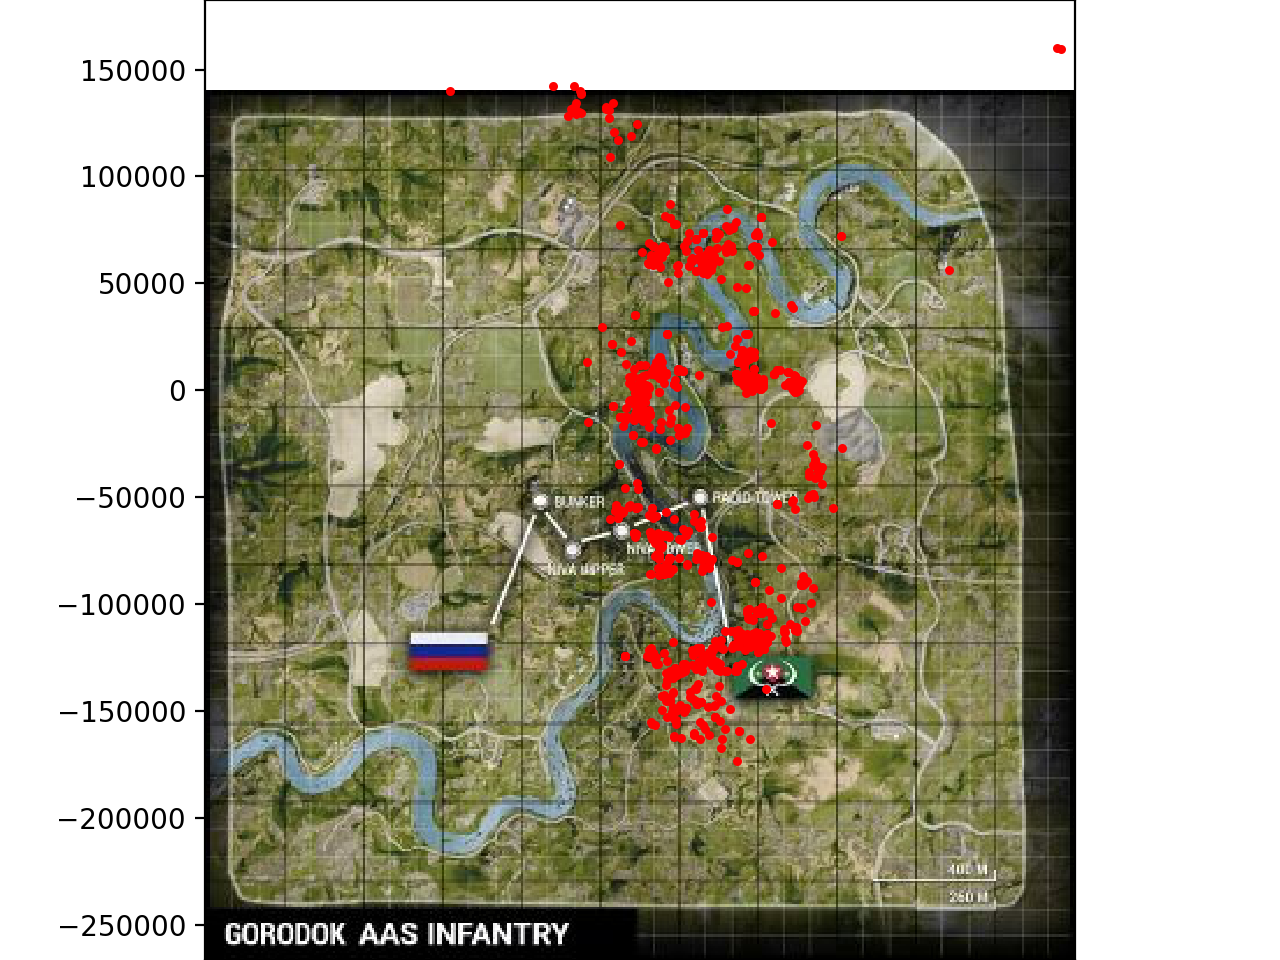

In [213]:
# plot kills

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# ([0, 0, 1, 1])
bg_figname = 'minimap_true.png'
img = plt.imread(bg_figname)
axis_extent = (-246400, 159990,
               -266400, 140000)
ax.imshow(img, extent=axis_extent)

for game in games:
    for event in game.events:
        pos_x, pos_y = event.player_kill_pos(game.id_data)
        ax.scatter(pos_x, pos_y, c='r', s=5)

<IPython.core.display.Javascript object>


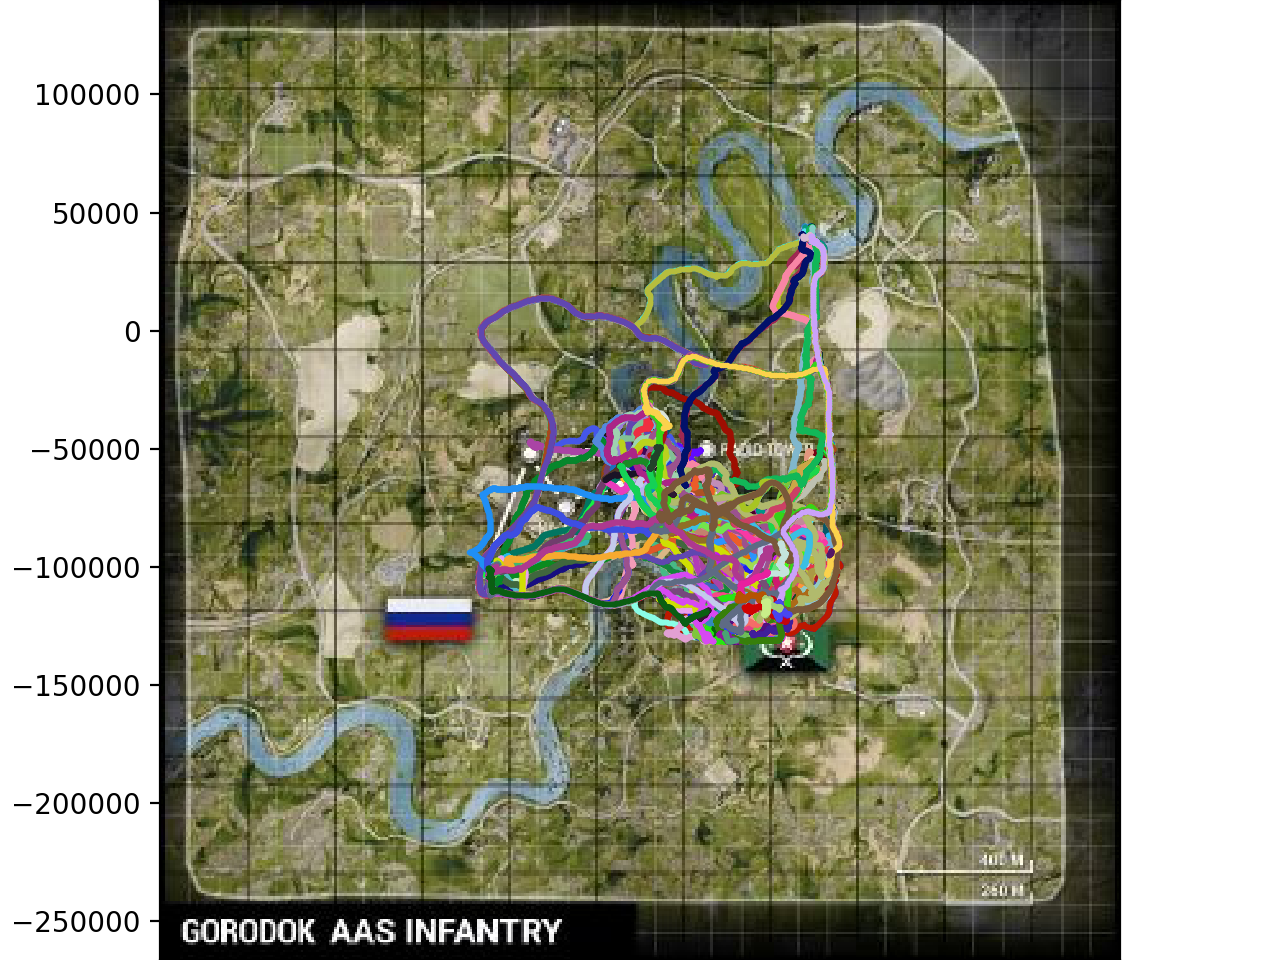

In [204]:
# plot movement
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
# ([0, 0, 1, 1])
bg_figname = 'minimap_true.png'
img = plt.imread(bg_figname)
axis_extent = (-246400, 159990,
               -266400, 140000)
ax.imshow(img, extent=axis_extent)

for player_key in games[0].players:
    player = players[player_key]
    player_indices = player.tick_indices
    pos_x = id_data['pos_x'][player_indices]
    pos_y = id_data['pos_y'][player_indices]
    ax.scatter(pos_x, pos_y, c=np.random.rand(3,), s=1)

In [ ]:
# Combined plot
